#**PROYECTO FINAL 2025 - INTELIGENCIA ARTIFICIAL**

In [1]:
# IMPORTS COMPLETOS DEL PROYECTO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from datetime import datetime

# Google Colab
from google.colab import drive

# Scikit-learn - Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Scikit-learn - Model Selection
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate

# Scikit-learn - Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

# Scikit-learn - Metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Scikit-learn - Dimensionality Reduction
from sklearn.decomposition import PCA

# Scikit-learn - Feature Selection
from sklearn.feature_selection import SelectKBest, f_regression

# Scipy - Statistics
from scipy import stats

# SHAP - Explainability
import shap

# Weights & Biases - Experiment Tracking
import wandb

# Joblib - Model Persistence
import joblib

# Configuraci√≥n
warnings.filterwarnings('ignore')
np.random.seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
np.random.seed(42)

# ====================================================================
# 1. CARGA Y EXPLORACI√ìN INICIAL DE DATOS
# ====================================================================

In [3]:
df = pd.read_csv('dfProductivity_KNN_cleaned.csv')
df = df.drop(columns=['perceived_productivity_score'])
print(f"Dimensiones: {df.shape}")
print(f"Variables: {df.columns.tolist()}")
print("\nInformaci√≥n general:")
print(df.info())

print("\nEstad√≠sticas descriptivas:")
print(df.describe())

Dimensiones: (30000, 18)
Variables: ['age', 'gender', 'job_type', 'daily_social_media_time', 'social_platform_preference', 'number_of_notifications', 'work_hours_per_day', 'actual_productivity_score', 'stress_level', 'sleep_hours', 'screen_time_before_sleep', 'breaks_during_work', 'uses_focus_apps', 'has_digital_wellbeing_enabled', 'coffee_consumption_per_day', 'days_feeling_burnout_per_month', 'weekly_offline_hours', 'job_satisfaction_score']

Informaci√≥n general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             30000 non-null  int64  
 1   gender                          30000 non-null  object 
 2   job_type                        30000 non-null  object 
 3   daily_social_media_time         30000 non-null  float64
 4   social_platform_preference      30000 non-null  o

# ====================================================================
# 2. FEATURE ENGINEERING
# ====================================================================


2.1 DISTRIBUCI√ìN DE LAS VARIABLES
Variables num√©ricas (15): ['age', 'daily_social_media_time', 'number_of_notifications', 'work_hours_per_day', 'actual_productivity_score', 'stress_level', 'sleep_hours', 'screen_time_before_sleep', 'breaks_during_work', 'uses_focus_apps', 'has_digital_wellbeing_enabled', 'coffee_consumption_per_day', 'days_feeling_burnout_per_month', 'weekly_offline_hours', 'job_satisfaction_score']
Variables categ√≥ricas (3): ['gender', 'job_type', 'social_platform_preference']


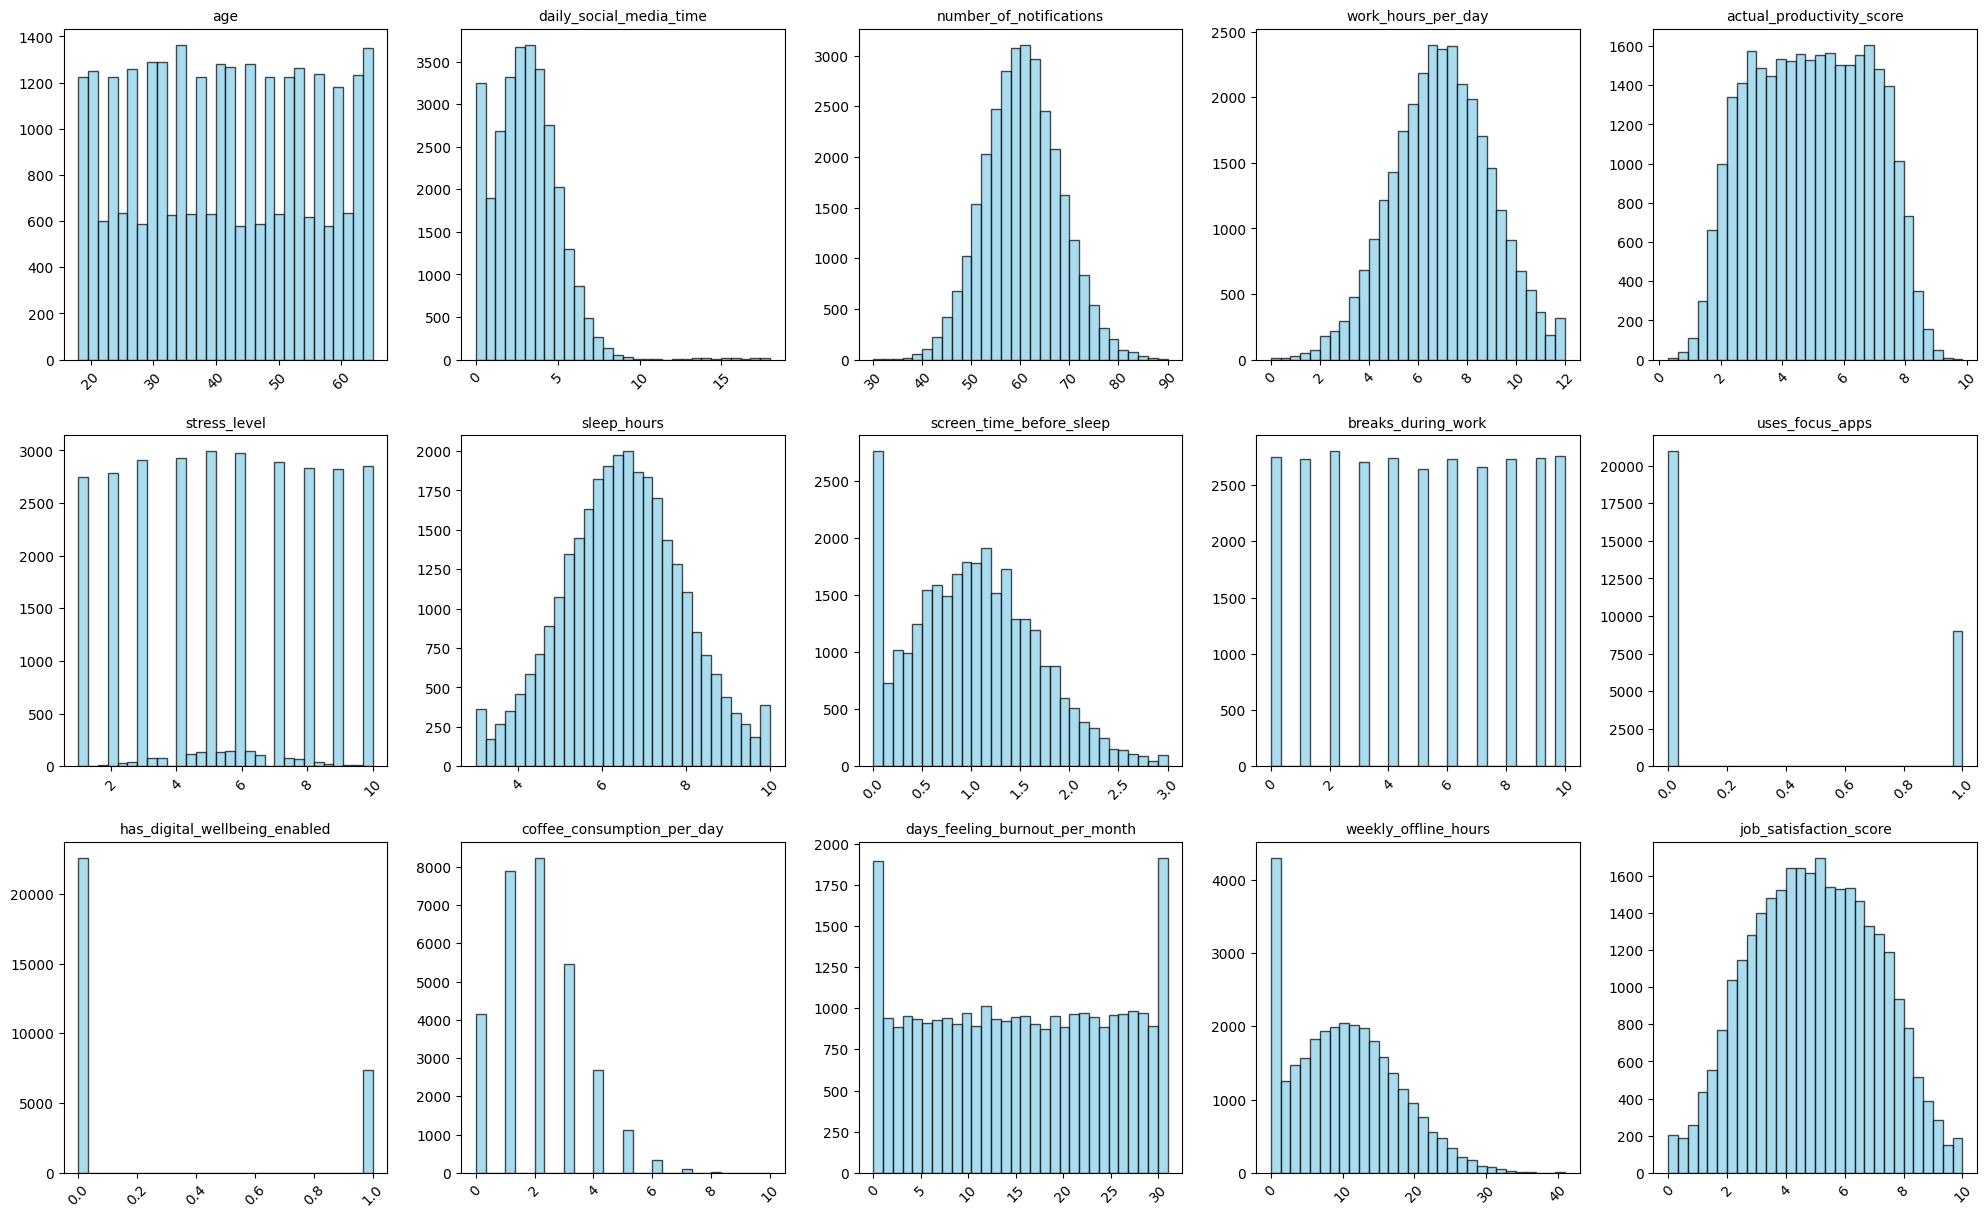


An√°lisis de asimetr√≠a (Skewness):
                      Variable  Skewness        Interpretaci√≥n
                           age  0.015305             Sim√©trica
       daily_social_media_time  1.202689           Muy sesgada
       number_of_notifications  0.117736             Sim√©trica
            work_hours_per_day -0.038135             Sim√©trica
     actual_productivity_score -0.009185             Sim√©trica
                  stress_level  0.002230             Sim√©trica
                   sleep_hours  0.007646             Sim√©trica
      screen_time_before_sleep  0.309716             Sim√©trica
            breaks_during_work  0.006698             Sim√©trica
               uses_focus_apps  0.869282 Moderadamente sesgada
 has_digital_wellbeing_enabled  1.175842           Muy sesgada
    coffee_consumption_per_day  0.674751 Moderadamente sesgada
days_feeling_burnout_per_month -0.007784             Sim√©trica
          weekly_offline_hours  0.423369             Sim√©trica
       

In [4]:
# 2.1 DISTRIBUCI√ìN DE LAS VARIABLES
print("\n2.1 DISTRIBUCI√ìN DE LAS VARIABLES")

# Variables num√©ricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"Variables num√©ricas ({len(numeric_cols)}): {numeric_cols}")
print(f"Variables categ√≥ricas ({len(categorical_cols)}): {categorical_cols}")

# Visualizaci√≥n de distribuciones
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
axes = axes.ravel()

for i, col in enumerate(numeric_cols):
    if i < len(axes):
        axes[i].hist(df[col].dropna(), bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[i].set_title(f'{col}', fontsize=10)
        axes[i].tick_params(axis='x', rotation=45)

# Ocultar subplots vac√≠os
for i in range(len(numeric_cols), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.savefig('distribucion_variables.png', dpi=300, bbox_inches='tight')
plt.show()

# An√°lisis de asimetr√≠a
print("\nAn√°lisis de asimetr√≠a (Skewness):")
skewness_data = []
for col in numeric_cols:
    skew_val = df[col].skew()
    skewness_data.append({'Variable': col, 'Skewness': skew_val, 'Interpretaci√≥n':
                         'Sim√©trica' if abs(skew_val) < 0.5 else
                         'Moderadamente sesgada' if abs(skew_val) < 1 else 'Muy sesgada'})

skewness_df = pd.DataFrame(skewness_data)
print(skewness_df.to_string(index=False))

**Explicaci√≥n del proceso**. Una vez visualizadas las distribuciones de las variables se comprueba que hay ciertas caracter√≠sticas con sesgo (moderados y altos) bas√°ndonos en skewness.

Intentamos mitigar esos sesgos de la siguiente forma:


*   Sesgo muy alto: aplicamos funci√≥n logaritmo a la caracater√≠stica.
*   Sesgo moderado: aplicamos funci√≥n ra√≠z cuadrada al ser menos agresiva, ya que el sesgo no es tan grave.


ESTUDIO DE CORRELACIONES


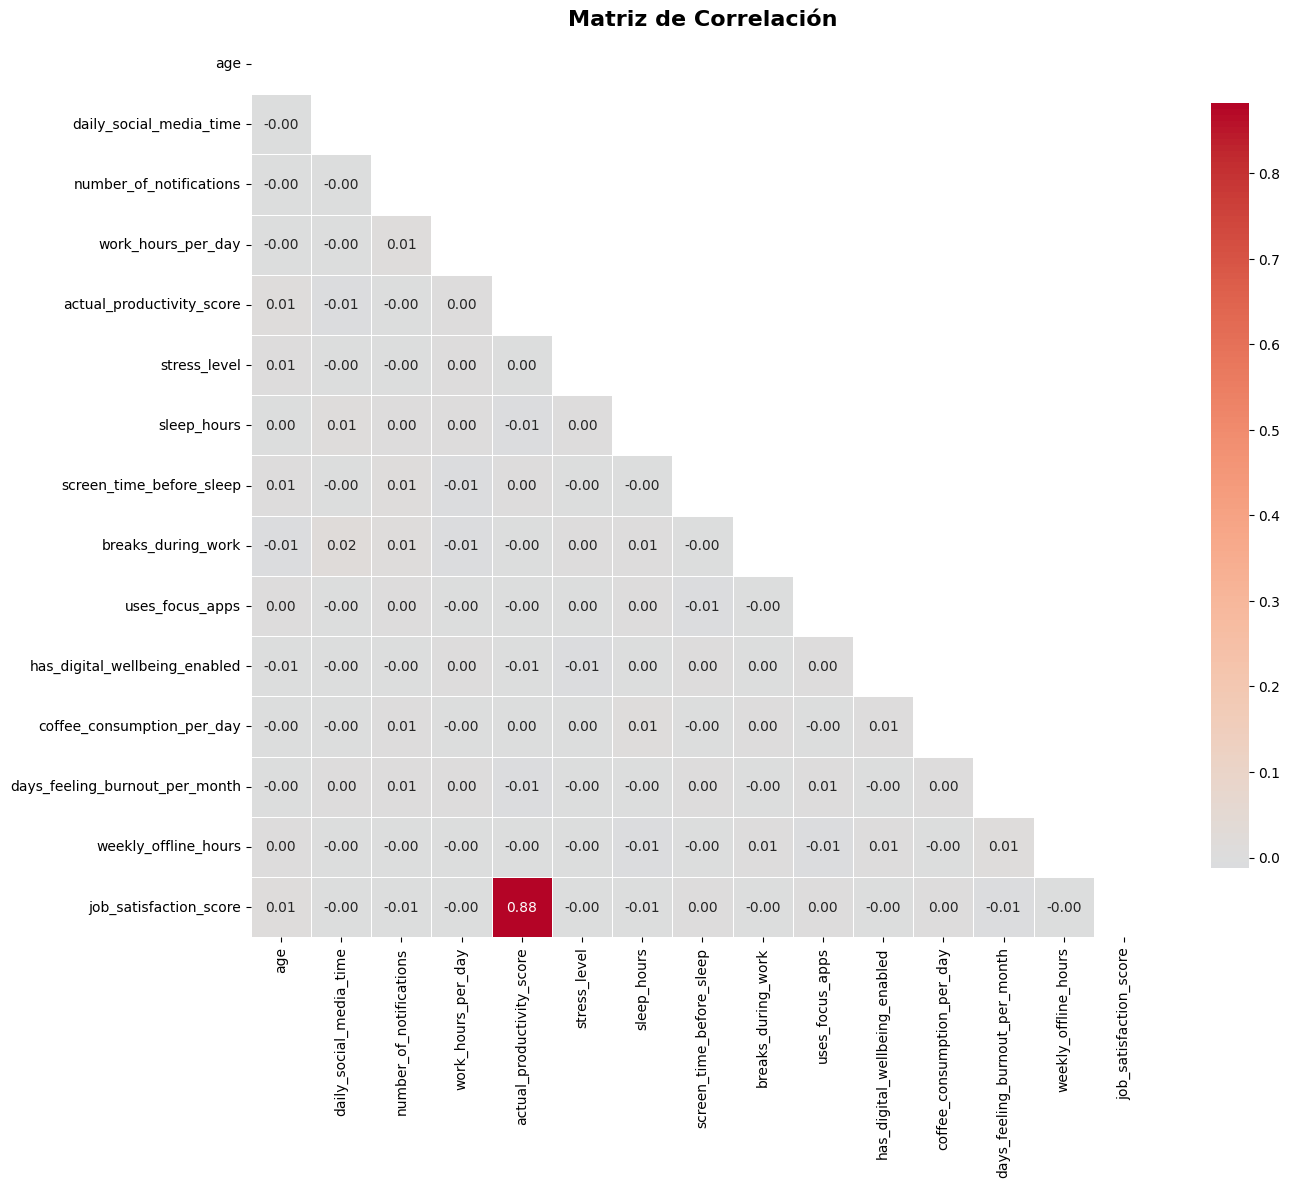


Correlaciones m√°s fuertes con 'actual_productivity_score':
   job_satisfaction_score: 0.882
   days_feeling_burnout_per_month: 0.013
   age: 0.011
   sleep_hours: 0.009
   daily_social_media_time: 0.007
   has_digital_wellbeing_enabled: 0.005
   weekly_offline_hours: 0.005
   breaks_during_work: 0.004
   screen_time_before_sleep: 0.002
   work_hours_per_day: 0.001
   uses_focus_apps: 0.001
   number_of_notifications: 0.001
   coffee_consumption_per_day: 0.000
   stress_level: 0.000


In [5]:
# 2.2 ESTUDIO DE CORRELACIONES
print("\nESTUDIO DE CORRELACIONES")

# Matriz de correlaci√≥n
correlation_matrix = df[numeric_cols].corr()

# Visualizaci√≥n de la matriz de correlaci√≥n
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8}, fmt='.2f')
plt.title('Matriz de Correlaci√≥n', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('matriz_correlacion.png', dpi=300, bbox_inches='tight')
plt.show()

# Correlaciones m√°s fuertes con la variable objetivo
target_correlations = correlation_matrix['actual_productivity_score'].abs().sort_values(ascending=False)
print(f"\nCorrelaciones m√°s fuertes con 'actual_productivity_score':")
for var, corr in target_correlations.items():
    if var != 'actual_productivity_score':
        print(f"   {var}: {corr:.3f}")

**Interpretaci√≥n**. Seg√∫n la matriz de Pearson no se han encontrado muchas relaciones lineales entre las caracter√≠sticas. √önicamente se ve relaci√≥n entre actual_productivity, job_satisfaction y perceived_productivity.

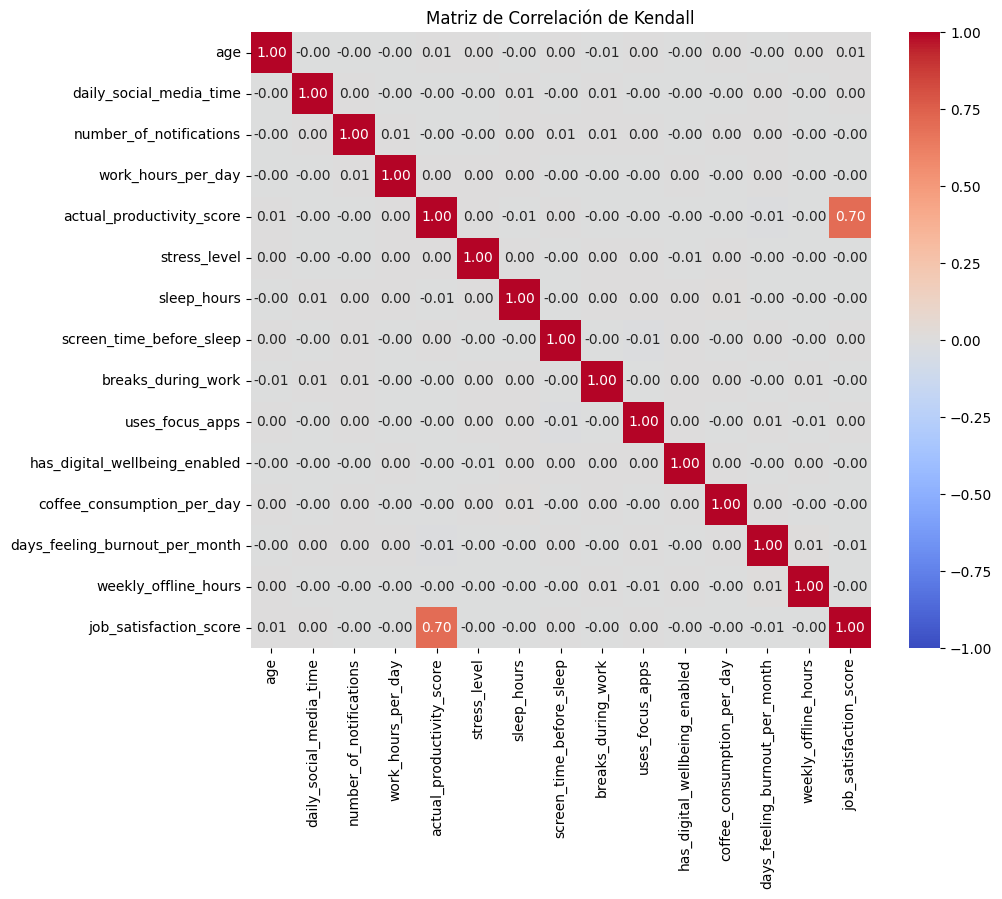

In [6]:
# Se ejecuta Kendall para comprobar relaciones no lineales de features

kendall_corr = df[numeric_cols].corr(method='kendall')
plt.figure(figsize=(10, 8))
sns.heatmap(kendall_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Matriz de Correlaci√≥n de Kendall')
plt.show()

**Interpretaci√≥n**. Dado que no se encontr√≥ relaci√≥n lineal con la matriz de Pearson, decidimos ver si con la matriz de Kendall se podr√≠an encontrar relaciones no lineales que no se pudiesen ver a simple vista.

A pesar de hacer la prueba, el resultado es el mismo.


2.3 VALORACI√ìN DE REDUCCI√ìN DE DIMENSIONALIDAD


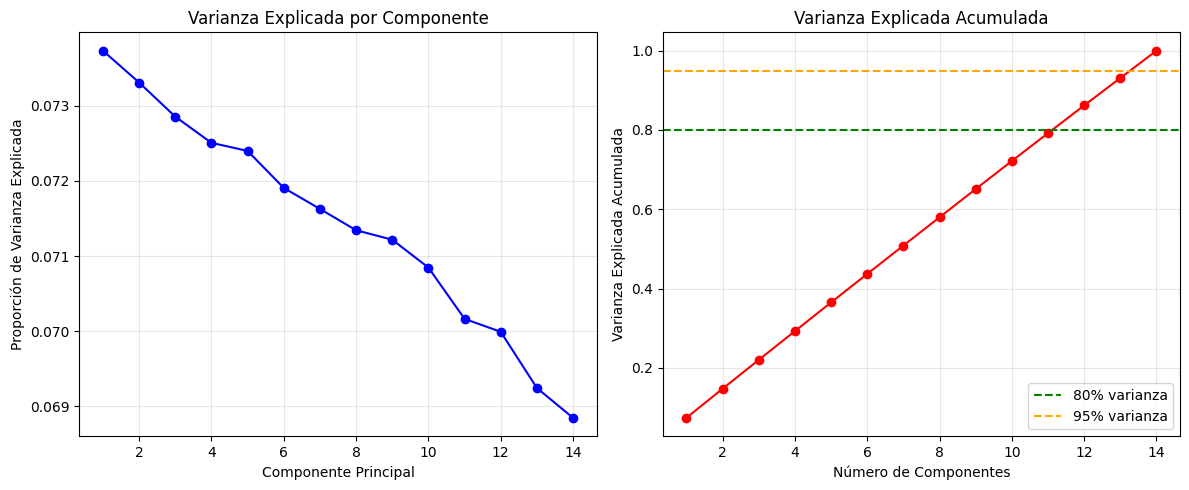

üìä Componentes necesarios para explicar:
   ‚Ä¢ 80% de la varianza: 12 componentes
   ‚Ä¢ 95% de la varianza: 14 componentes
   ‚Ä¢ Total de variables originales: 14


In [7]:
# 2.3 VALORACI√ìN DE REDUCCI√ìN DE DIMENSIONALIDAD
print("\n2.3 VALORACI√ìN DE REDUCCI√ìN DE DIMENSIONALIDAD")

# Preparar datos para PCA (solo variables num√©ricas, excluir target)
X_numeric = df[numeric_cols].drop(['actual_productivity_score'], axis=1)
X_numeric_scaled = StandardScaler().fit_transform(X_numeric)

# Aplicar PCA
pca = PCA()
X_pca = pca.fit_transform(X_numeric_scaled)

# Varianza explicada acumulada
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(12, 5))

# Gr√°fico de varianza explicada
plt.subplot(1, 2, 1)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, 'bo-')
plt.title('Varianza Explicada por Componente')
plt.xlabel('Componente Principal')
plt.ylabel('Proporci√≥n de Varianza Explicada')
plt.grid(True, alpha=0.3)

# Gr√°fico de varianza acumulada
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'ro-')
plt.axhline(y=0.8, color='g', linestyle='--', label='80% varianza')
plt.axhline(y=0.95, color='orange', linestyle='--', label='95% varianza')
plt.title('Varianza Explicada Acumulada')
plt.xlabel('N√∫mero de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('analisis_pca.png', dpi=300, bbox_inches='tight')
plt.show()

# Encontrar n√∫mero de componentes para 80% y 95% de varianza
n_components_80 = np.argmax(cumulative_variance >= 0.8) + 1
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"üìä Componentes necesarios para explicar:")
print(f"   ‚Ä¢ 80% de la varianza: {n_components_80} componentes")
print(f"   ‚Ä¢ 95% de la varianza: {n_components_95} componentes")
print(f"   ‚Ä¢ Total de variables originales: {len(X_numeric.columns)}")

**Interpretaci√≥n**. Hemos aplicado PCA para comprobar si de alguna forma podemos reducir la dimensionalidad utilizando el menor n√∫mero de caracter√≠sicas con la mayor exlicabilidad de la varianza.

Finalmente, el dataset sigue con el mismo n√∫mero de componentes principales, ya que las 13 cracter√≠sticas num√©ricas explican el 95% de la varianza total.

In [8]:
# 2.5 FUNCI√ìN DE TRANSFORMACI√ìN COMPLETA
print("\n2.5 FUNCI√ìN DE TRANSFORMACI√ìN COMPLETA")

def transform_data(df, target_col='actual_productivity_score', test_mode=False, scaler=None, encoders=None):
    """
    Funci√≥n completa para transformar datos desde lectura hasta preparaci√≥n para ML

    Parameters:
    -----------
    df : pandas.DataFrame
        Dataset original
    target_col : str
        Nombre de la variable objetivo
    test_mode : bool
        Si es True, usa transformadores ya ajustados (para datos de test)
    scaler : sklearn.preprocessing.StandardScaler
        Escalador pre-ajustado (solo para test_mode=True)
    encoders : dict
        Diccionario de encoders pre-ajustados (solo para test_mode=True)

    Returns:
    --------
    X_transformed : numpy.array
        Features transformadas
    y : numpy.array or None
        Variable objetivo (None si no est√° presente)
    scaler : sklearn.preprocessing.StandardScaler
        Escalador ajustado
    encoders : dict
        Diccionario de encoders ajustados
    feature_names : list
        Nombres de las features finales
    """

    df_processed = df.copy()

    # 1. Manejo de valores faltantes (si los hay)
    numeric_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()
    if target_col in numeric_cols:
        numeric_cols.remove(target_col)

    categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()

    # Imputaci√≥n simple para valores faltantes
    for col in numeric_cols:
        if df_processed[col].isnull().sum() > 0:
            df_processed[col].fillna(df_processed[col].median(), inplace=True)

    for col in categorical_cols:
        if df_processed[col].isnull().sum() > 0:
            df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)

    # 2. Encoding de variables categ√≥ricas
    if not test_mode:
        encoders = {}

    encoded_dfs = []

    for col in categorical_cols:
        if not test_mode:
            # Crear y ajustar encoder
            le = LabelEncoder()
            encoded_col = le.fit_transform(df_processed[col])
            encoders[col] = le
        else:
            # Usar encoder pre-ajustado
            le = encoders[col]
            # Manejar categor√≠as no vistas
            encoded_col = []
            for val in df_processed[col]:
                try:
                    encoded_col.append(le.transform([val])[0])
                except ValueError:
                    # Categor√≠a no vista, asignar valor m√°s frecuente
                    encoded_col.append(0)
            encoded_col = np.array(encoded_col)

        encoded_dfs.append(pd.DataFrame({f'{col}_encoded': encoded_col}))

    # 3. Combinar features num√©ricas y categ√≥ricas codificadas
    X = pd.concat([df_processed[numeric_cols]] + encoded_dfs, axis=1)

    # 4. Tratamiento de asimetr√≠ia
    print("Aplicando transformaciones de asimetr√≠a...")

    # Definir transformaciones basadas en an√°lisis de skewness
    skewed_transformations = {
        # Variables muy sesgadas (|skew| > 1.0) -> log1p
        'daily_social_media_time': 'log1p',
        'has_digital_wellbeing_enabled': 'log1p',

        # Variables moderadamente sesgadas (0.5 < |skew| < 1.0) -> sqrt
        'uses_focus_apps': 'sqrt',
        'coffee_consumption_per_day': 'sqrt'
    }

    transformations_applied = []

    for original_col, transform_type in skewed_transformations.items():
        if original_col in X.columns:
            try:
                if transform_type == 'log1p':
                    # log1p es m√°s estable que log para valores que pueden ser 0
                    X[f'{original_col}_log'] = np.log1p(X[original_col])
                    transformations_applied.append(f'{original_col} -> log1p')

                elif transform_type == 'sqrt':
                    # Asegurar valores no negativos para sqrt
                    X[f'{original_col}_sqrt'] = np.sqrt(np.maximum(0, X[original_col]))
                    transformations_applied.append(f'{original_col} -> sqrt')

            except Exception as e:
                print(f"   ‚ö†Ô∏è Error transformando {original_col}: {e}")

    if not test_mode and transformations_applied:
        print(f"   ‚úÖ Transformaciones aplicadas: {len(transformations_applied)}")
        for transform in transformations_applied:
            print(f"      ‚Ä¢ {transform}")

    # 5. Crear features adicionales (engineering)
    # Ratios e interacciones √∫tiles
    if 'daily_social_media_time' in X.columns and 'work_hours_per_day' in X.columns:
        X['social_work_ratio'] = X['daily_social_media_time'] / (X['work_hours_per_day'] + 1e-6)

    if 'sleep_hours' in X.columns and 'work_hours_per_day' in X.columns:
        X['sleep_work_ratio'] = X['sleep_hours'] / (X['work_hours_per_day'] + 1e-6)

    if 'daily_social_media_time' in X.columns and 'screen_time_before_sleep' in X.columns:
        X['total_screen_time'] = X['daily_social_media_time'] + X['screen_time_before_sleep']

    if 'perceived_productivity_score' in X.columns:
        # Solo crear si no es la variable objetivo
        if target_col != 'perceived_productivity_score':
            actual_score = X.get('actual_productivity_score', 0)
            X['productivity_gap'] = X['perceived_productivity_score'] - actual_score

    if 'stress_level' in X.columns and 'job_satisfaction_score' in X.columns:
        X['stress_satisfaction_ratio'] = X['stress_level'] / (X['job_satisfaction_score'] + 1e-6)

    # Variables booleanas como num√©ricas (si no fueron transformadas ya)
    bool_cols = ['uses_focus_apps', 'has_digital_wellbeing_enabled']
    for col in bool_cols:
        if col in df_processed.columns and col in X.columns:
            X[col] = X[col].astype(int)

    # 6. SELECCI√ìN DE FEATURES MEJORADA
    # Eliminar variables originales si fueron transformadas por asimetr√≠a
    original_skewed_vars = list(skewed_transformations.keys())

    # Mantener tanto originales como transformadas por ahora,
    # la correlaci√≥n alta las eliminar√° si es necesario
    print(f"   Features antes de selecci√≥n: {len(X.columns)}")

    # Eliminar correlaciones muy altas
    correlation_matrix = X.corr().abs()
    upper_triangle = correlation_matrix.where(
        np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
    )

    # Encontrar features con correlaci√≥n > 0.95
    high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]

    # Preferir versiones transformadas sobre originales
    features_to_drop = []
    for feature in high_corr_features:
        # Si la feature original tiene una versi√≥n transformada, eliminar la original
        base_name = feature.replace('_log', '').replace('_sqrt', '')
        if base_name in original_skewed_vars:
            if feature == base_name:  # Es la versi√≥n original
                # Verificar si existe la transformada
                transformed_exists = any(f'{base_name}_log' in X.columns or f'{base_name}_sqrt' in X.columns)
                if transformed_exists:
                    features_to_drop.append(feature)
                    continue
        features_to_drop.append(feature)

    # Eliminar duplicados
    features_to_drop = list(set(features_to_drop))
    X = X.drop(columns=features_to_drop)

    if features_to_drop:
        print(f"   Features eliminadas por alta correlaci√≥n: {len(features_to_drop)}")
        print(f"   Features finales: {len(X.columns)}")

    # 7. Escalado de features
    if not test_mode:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = scaler.transform(X)

    # 8. Preparar variable objetivo
    y = None
    if target_col in df_processed.columns:
        y = df_processed[target_col].values

    feature_names = X.columns.tolist()

    return X_scaled, y, scaler, encoders, feature_names

# ACTUALIZAR LA PRUEBA DE LA FUNCI√ìN
print("\nProbando funci√≥n de transformaci√≥n actualizada...")
X_transformed, y, scaler_fitted, encoders_fitted, feature_names = transform_data(df)

print(f"\n‚úÖ Transformaci√≥n completada:")
print(f"   ‚Ä¢ Shape de X: {X_transformed.shape}")
print(f"   ‚Ä¢ Shape de y: {y.shape}")
print(f"   ‚Ä¢ Features finales: {len(feature_names)}")
print(f"\nFeatures creadas:")
for i, name in enumerate(feature_names):
  print(f"   {i+1:2d}. {name}")


2.5 FUNCI√ìN DE TRANSFORMACI√ìN COMPLETA

Probando funci√≥n de transformaci√≥n actualizada...
Aplicando transformaciones de asimetr√≠a...
   ‚úÖ Transformaciones aplicadas: 4
      ‚Ä¢ daily_social_media_time -> log1p
      ‚Ä¢ has_digital_wellbeing_enabled -> log1p
      ‚Ä¢ uses_focus_apps -> sqrt
      ‚Ä¢ coffee_consumption_per_day -> sqrt
   Features antes de selecci√≥n: 25
   Features eliminadas por alta correlaci√≥n: 3
   Features finales: 22

‚úÖ Transformaci√≥n completada:
   ‚Ä¢ Shape de X: (30000, 22)
   ‚Ä¢ Shape de y: (30000,)
   ‚Ä¢ Features finales: 22

Features creadas:
    1. age
    2. daily_social_media_time
    3. number_of_notifications
    4. work_hours_per_day
    5. stress_level
    6. sleep_hours
    7. screen_time_before_sleep
    8. breaks_during_work
    9. uses_focus_apps
   10. has_digital_wellbeing_enabled
   11. coffee_consumption_per_day
   12. days_feeling_burnout_per_month
   13. weekly_offline_hours
   14. job_satisfaction_score
   15. gender_encode

# ====================================================================
# 3. ENTRENAMIENTO DE MODELOS
# ====================================================================

In [9]:
# 3.1 DIVISI√ìN DE DATOS
print("\n3.1 DIVISI√ìN DE DATOS")

X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y, test_size=0.2, random_state=42, stratify=None
)

print(f"Divisi√≥n completada:")
print(f"   ‚Ä¢ Entrenamiento: {X_train.shape[0]} muestras")
print(f"   ‚Ä¢ Test: {X_test.shape[0]} muestras")


3.1 DIVISI√ìN DE DATOS
Divisi√≥n completada:
   ‚Ä¢ Entrenamiento: 24000 muestras
   ‚Ä¢ Test: 6000 muestras


In [10]:
# 3.2 DEFINICI√ìN DE MODELOS
print("\n3.2 DEFINICI√ìN DE MODELOS")

models = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1, 0.15],
            'max_depth': [3, 5, 7]
        }
    },
    'Neural Network': {
        'model': MLPRegressor(random_state=42, max_iter=1000),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
            'activation': ['relu', 'tanh'],
            'alpha': [0.001, 0.01, 0.1],
            'learning_rate': ['adaptive']
        }
    }
}

print(f"Modelos a entrenar: {list(models.keys())}")

# # 3.2 DEFINICI√ìN DE MODELOS (VERSI√ìN ULTRA-R√ÅPIDA)
# print("\n3.2 DEFINICI√ìN DE MODELOS (OPTIMIZADO PARA VELOCIDAD)")

# # Opci√≥n 1: SIN GridSearch (RECOMENDADO para 30k filas)
# models = {
#     'Linear Regression': {
#         'model': LinearRegression(),
#         'params': {}
#     },
#     'Random Forest': {
#         'model': RandomForestRegressor(
#             n_estimators=100,           # Valor fijo razonable
#             max_depth=15,              # Valor fijo razonable
#             min_samples_split=5,       # Valor fijo razonable
#             random_state=42,
#             n_jobs=-1
#         ),
#         'params': {}
#     },
#     'Gradient Boosting': {
#         'model': GradientBoostingRegressor(
#             n_estimators=100,          # Valor fijo razonable
#             learning_rate=0.1,         # Valor fijo razonable
#             max_depth=5,               # Valor fijo razonable
#             random_state=42
#         ),
#         'params': {}
#     },
#     'Neural Network': {
#         'model': MLPRegressor(
#             hidden_layer_sizes=(100,), # Arquitectura fija razonable
#             activation='relu',         # Activaci√≥n fija
#             alpha=0.01,               # Regularizaci√≥n fija
#             max_iter=300,             # Menos iteraciones
#             early_stopping=True,      # Para en convergencia
#             random_state=42
#         ),
#         'params': {}
#     }
# }



3.2 DEFINICI√ìN DE MODELOS
Modelos a entrenar: ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'Neural Network']


In [13]:
# 3.3 INICIALIZAR WANDB
wandb.init(
    project="redes-sociales-productividad",
    name=f"experimento-{datetime.now().strftime('%Y%m%d-%H%M%S')}",
    entity='aapradodarriba-ntt-data',
    config={
        "dataset_size": len(df),
        "test_size": 0.2,
        "random_state": 42,
        "target_variable": "actual_productivity_score",
        "problem_type": "regression",
        "models": list(models.keys()),
        "features_count": len(feature_names)
    },
    tags=["productividad", "redes-sociales", "proyecto-final"]
)

print(f"Weights & Biases inicializado")
print(f"Dashboard: {wandb.run.url}")

# Log informaci√≥n del dataset
wandb.log({
    "dataset/total_samples": len(df),
    "dataset/features": len(df.columns),
    "dataset/target_mean": df['actual_productivity_score'].mean(),
    "dataset/target_std": df['actual_productivity_score'].std(),
    "dataset/unique_values": len(df['actual_productivity_score'].unique())
})

Weights & Biases inicializado
Dashboard: https://wandb.ai/aapradodarriba-ntt-data/redes-sociales-productividad/runs/wkrfjvfa


In [15]:
# 3.4 ENTRENAMIENTO UNIFICADO CON WANDB
print("\n3.4 ENTRENAMIENTO Y EVALUACI√ìN UNIFICADO")

results = {}
all_metrics = {}

for name, model_config in models.items():
    print(f"\nüîÑ Entrenando {name}...")
    start_time = time.time()

    # GridSearch o entrenamiento directo
    if model_config['params']:
        print(f"   üîç B√∫squeda de hiperpar√°metros...")
        grid_search = GridSearchCV(
            model_config['model'],
            model_config['params'],
            cv=3,
            scoring='r2',
            n_jobs=-1,
            verbose=1
        )

        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_

        # Log hiperpar√°metros
        # wandb.log({f"{name}/best_cv_score": grid_search.best_score_})
        print(f"   Mejores par√°metros: {best_params}")
        print(f"   Mejor CV score: {grid_search.best_score_:.4f}")

    else:
        best_model = model_config['model']
        best_model.fit(X_train, y_train)
        best_params = "No hyperparameter tuning"

    training_time = time.time() - start_time

    # Predicciones
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # M√©tricas completas
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    overfitting = train_r2 - test_r2

    # Cross-validation detallada
    cv_scores = cross_validate(
        best_model, X_train, y_train,
        cv=5,
        scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'],
        return_train_score=True
    )

    cv_r2_mean = cv_scores['test_r2'].mean()
    cv_r2_std = cv_scores['test_r2'].std()
    cv_mse_mean = -cv_scores['test_neg_mean_squared_error'].mean()

    # Compilar m√©tricas
    metrics = {
        f"{name}/train_mse": train_mse,
        f"{name}/train_r2": train_r2,
        f"{name}/train_mae": train_mae,
        f"{name}/test_mse": test_mse,
        f"{name}/test_r2": test_r2,
        f"{name}/test_mae": test_mae,
        f"{name}/cv_r2_mean": cv_r2_mean,
        f"{name}/cv_r2_std": cv_r2_std,
        f"{name}/cv_mse_mean": cv_mse_mean,
        f"{name}/overfitting": overfitting,
        f"{name}/training_time": training_time
    }

    # Log m√©tricas a wandb
    wandb.log(metrics)

    # Guardar en results (formato original para compatibilidad)
    results[name] = {
        'model': best_model,
        'best_params': best_params,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'cv_mse': cv_mse_mean,
        'cv_std': cv_r2_std,
        'training_time': training_time,
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred
    }

    # Visualizaciones autom√°ticas
    fig_pred = plt.figure(figsize=(15, 5))

    # Predicciones vs Reales
    plt.subplot(1, 3, 1)
    plt.scatter(y_test, y_test_pred, alpha=0.5, s=1)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Valores Reales')
    plt.ylabel('Predicciones')
    plt.title(f'{name} - Predicciones vs Reales')
    plt.grid(True, alpha=0.3)

    # Residuos
    plt.subplot(1, 3, 2)
    residuals = y_test - y_test_pred
    plt.scatter(y_test_pred, residuals, alpha=0.5, s=1)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicciones')
    plt.ylabel('Residuos')
    plt.title(f'{name} - An√°lisis de Residuos')
    plt.grid(True, alpha=0.3)

    # Distribuci√≥n de errores
    plt.subplot(1, 3, 3)
    plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
    plt.axvline(residuals.mean(), color='red', linestyle='--',
                label=f'Media: {residuals.mean():.3f}')
    plt.xlabel('Residuos')
    plt.ylabel('Frecuencia')
    plt.title(f'{name} - Distribuci√≥n de Errores')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    wandb.log({f"analysis/{name.lower().replace(' ', '_')}": wandb.Image(fig_pred)})
    plt.close()

    # Feature importance si est√° disponible
    if hasattr(best_model, 'feature_importances_'):
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False)

        # Log tabla
        wandb.log({f"feature_importance_table/{name.lower().replace(' ', '_')}":
                   wandb.Table(dataframe=importance_df.head(15))})

        # Gr√°fico de importancia
        fig_imp = plt.figure(figsize=(12, 8))
        top_features = importance_df.head(15)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Importancia')
        plt.title(f'Feature Importance - {name}')
        plt.gca().invert_yaxis()
        plt.grid(True, axis='x', alpha=0.3)
        plt.tight_layout()

        wandb.log({f"feature_importance_plot/{name.lower().replace(' ', '_')}": wandb.Image(fig_imp)})
        plt.close()

    # Mostrar resultados
    print(f"   ‚úÖ {name} completado:")
    print(f"      ‚Ä¢ R¬≤ Test: {test_r2:.4f}")
    print(f"      ‚Ä¢ MSE Test: {test_mse:.4f}")
    print(f"      ‚Ä¢ Overfitting: {overfitting:.4f}")
    print(f"      ‚Ä¢ CV R¬≤: {cv_r2_mean:.4f} (¬±{cv_r2_std:.4f})")
    print(f"      ‚Ä¢ Tiempo: {training_time:.1f}s")



3.4 ENTRENAMIENTO Y EVALUACI√ìN UNIFICADO

üîÑ Entrenando Linear Regression...
   ‚úÖ Linear Regression completado:
      ‚Ä¢ R¬≤ Test: 0.7762
      ‚Ä¢ MSE Test: 0.7747
      ‚Ä¢ Overfitting: 0.0033
      ‚Ä¢ CV R¬≤: 0.7788 (¬±0.0037)
      ‚Ä¢ Tiempo: 0.0s

üîÑ Entrenando Random Forest...
   üîç B√∫squeda de hiperpar√°metros...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
   Mejores par√°metros: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
   Mejor CV score: 0.7847
   ‚úÖ Random Forest completado:
      ‚Ä¢ R¬≤ Test: 0.7848
      ‚Ä¢ MSE Test: 0.7449
      ‚Ä¢ Overfitting: 0.0548
      ‚Ä¢ CV R¬≤: 0.7850 (¬±0.0038)
      ‚Ä¢ Tiempo: 285.9s

üîÑ Entrenando Gradient Boosting...
   üîç B√∫squeda de hiperpar√°metros...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
   Mejores par√°metros: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
   Mejor CV score: 0.7874
   ‚úÖ Gradient Boosting completado:
      ‚Ä¢ R¬≤ Test: 0.78

In [16]:
# 3.5 COMPARACI√ìN FINAL Y SELECCI√ìN DEL MEJOR MODELO
print("\n3.5 AN√ÅLISIS FINAL Y SELECCI√ìN")

# Crear tabla de comparaci√≥n
comparison_data = []
for name, result in results.items():
    comparison_data.append({
        'modelo': name,
        'test_r2': result['test_r2'],
        'test_mse': result['test_mse'],
        'test_mae': result['test_mae'],
        'overfitting': result['train_r2'] - result['test_r2'],
        'cv_r2_mean': result.get('cv_mse', 0),  # Usando cv_mse como proxy
        'training_time': result['training_time']
    })

comparison_df = pd.DataFrame(comparison_data)

# Log tabla comparativa
wandb.log({"final/model_comparison": wandb.Table(dataframe=comparison_df)})

# Selecci√≥n del mejor modelo (criterios m√∫ltiples)
selection_criteria = {}
for name, result in results.items():
    score = (
        result['test_r2'] * 0.4 +  # 40% R¬≤ en test
        (1 - result['test_mse'] / max([r['test_mse'] for r in results.values()])) * 0.3 +
        (1 - abs(result['train_r2'] - result['test_r2'])) * 0.3  # 30% anti-overfitting
    )
    selection_criteria[name] = score

best_model_name = max(selection_criteria.keys(), key=lambda k: selection_criteria[k])
best_result = results[best_model_name]

# Gr√°fico comparativo final
fig_final = plt.figure(figsize=(16, 10))

# R¬≤ Comparison
plt.subplot(2, 3, 1)
plt.bar(comparison_df['modelo'], comparison_df['test_r2'], color='skyblue')
plt.title('R¬≤ en Test')
plt.xticks(rotation=45)
plt.ylabel('R¬≤')
plt.grid(True, alpha=0.3)

# MSE Comparison
plt.subplot(2, 3, 2)
plt.bar(comparison_df['modelo'], comparison_df['test_mse'], color='lightcoral')
plt.title('MSE en Test')
plt.xticks(rotation=45)
plt.ylabel('MSE')
plt.grid(True, alpha=0.3)

# Overfitting
plt.subplot(2, 3, 3)
colors = ['red' if x > 0.05 else 'green' for x in comparison_df['overfitting']]
plt.bar(comparison_df['modelo'], comparison_df['overfitting'], color=colors, alpha=0.7)
plt.title('Overfitting (Train R¬≤ - Test R¬≤)')
plt.xticks(rotation=45)
plt.ylabel('Diferencia R¬≤')
plt.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='Umbral 5%')
plt.legend()
plt.grid(True, alpha=0.3)

# Training Time
plt.subplot(2, 3, 4)
plt.bar(comparison_df['modelo'], comparison_df['training_time'], color='lightgreen')
plt.title('Tiempo de Entrenamiento')
plt.xticks(rotation=45)
plt.ylabel('Segundos')
plt.grid(True, alpha=0.3)

# Ranking final
plt.subplot(2, 3, 5)
sorted_models = sorted(selection_criteria.items(), key=lambda x: x[1], reverse=True)
models_sorted = [x[0] for x in sorted_models]
scores_sorted = [x[1] for x in sorted_models]
colors = ['gold' if model == best_model_name else 'lightgray' for model in models_sorted]
plt.bar(models_sorted, scores_sorted, color=colors)
plt.title('Ranking Final (Score Combinado)')
plt.xticks(rotation=45)
plt.ylabel('Score')
plt.grid(True, alpha=0.3)

# Summary del mejor modelo
plt.subplot(2, 3, 6)
summary_text = f"""MEJOR MODELO: {best_model_name}

M√âTRICAS:
- R¬≤ Test: {best_result['test_r2']:.4f}
- MSE Test: {best_result['test_mse']:.4f}
- MAE Test: {best_result['test_mae']:.4f}
- Overfitting: {abs(best_result['train_r2'] - best_result['test_r2']):.4f}

TIEMPO: {best_result['training_time']:.1f}s
SCORE: {selection_criteria[best_model_name]:.4f}"""

plt.text(0.05, 0.95, summary_text, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', fontfamily='monospace')
plt.axis('off')

plt.tight_layout()
wandb.log({"final/comparison_dashboard": wandb.Image(fig_final)})
plt.close()

# Summary para wandb
wandb.summary.update({
    "best_model": best_model_name,
    "best_test_r2": best_result['test_r2'],
    "best_test_mse": best_result['test_mse'],
    "best_overfitting": abs(best_result['train_r2'] - best_result['test_r2']),
    "total_training_time": sum([r['training_time'] for r in results.values()]),
    "experiment_completed": True
})

print(f"\nEXPERIMENTO COMPLETADO!")
print(f"Dashboard: {wandb.run.url}")
print(f"\nRESULTADO FINAL:")
print(f"   Mejor modelo: {best_model_name}")
print(f"   R¬≤ en test: {best_result['test_r2']:.4f}")
print(f"   MSE en test: {best_result['test_mse']:.4f}")
print(f"   Overfitting: {abs(best_result['train_r2'] - best_result['test_r2']):.4f}")

# Finalizar wandb
# wandb.finish()


3.5 AN√ÅLISIS FINAL Y SELECCI√ìN

EXPERIMENTO COMPLETADO!
Dashboard: https://wandb.ai/aapradodarriba-ntt-data/redes-sociales-productividad/runs/wkrfjvfa

RESULTADO FINAL:
   Mejor modelo: Gradient Boosting
   R¬≤ en test: 0.7867
   MSE en test: 0.7382
   Overfitting: 0.0051


AN√ÅLISIS SHAP - Gradient Boosting


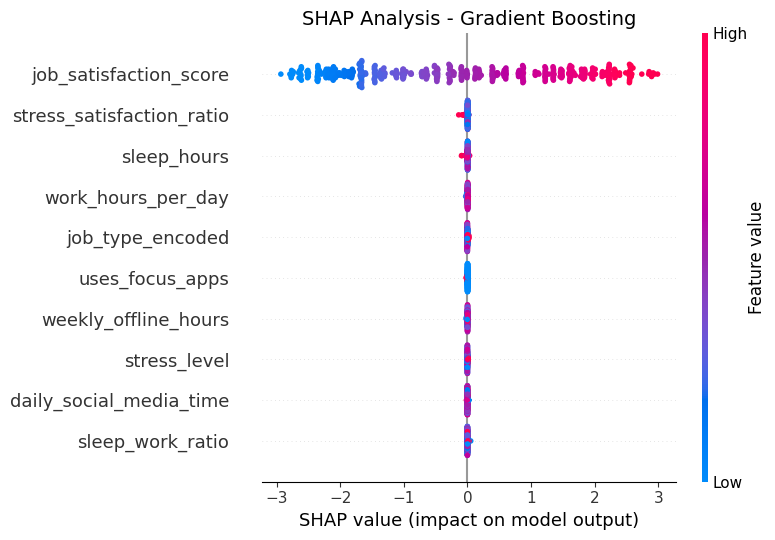


TOP 10 FEATURES - AN√ÅLISIS SHAP:
Feature                   Importancia  Impacto Promedio
-------------------------------------------------------
job_satisfaction_score    1.4241       -0.0554  ‚Üì Disminuye
stress_satisfaction_ratio 0.0050       0.0013   ‚Üë Aumenta
sleep_hours               0.0046       -0.0000  ‚Üì Disminuye
work_hours_per_day        0.0043       -0.0001  ‚Üì Disminuye
job_type_encoded          0.0033       0.0005   ‚Üë Aumenta
uses_focus_apps           0.0032       0.0001   ‚Üë Aumenta
weekly_offline_hours      0.0030       -0.0002  ‚Üì Disminuye
stress_level              0.0025       -0.0001  ‚Üì Disminuye
daily_social_media_time   0.0017       -0.0001  ‚Üì Disminuye
sleep_work_ratio          0.0014       -0.0000  ‚Üì Disminuye


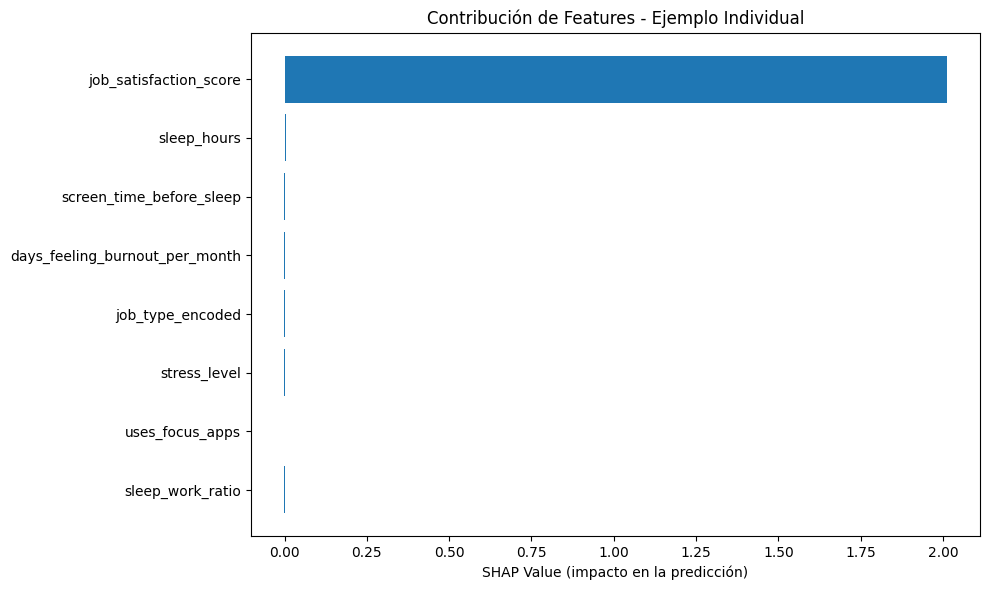


INSIGHTS CLAVE:
Factores que DISMINUYEN productividad:
      ‚Ä¢ job_satisfaction_score: -0.055


In [17]:
# AN√ÅLISIS SHAP
import shap
import numpy as np

# Solo para modelos tree-based (Random Forest, Gradient Boosting)
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    print(f"AN√ÅLISIS SHAP - {best_model_name}")

    # 1. Crear explainer
    best_model_obj = results[best_model_name]['model']
    explainer = shap.TreeExplainer(best_model_obj)

    # 2. Calcular SHAP values (muestra peque√±a para velocidad)
    sample_size = min(500, len(X_test))
    X_sample = X_test[:sample_size]
    shap_values = explainer.shap_values(X_sample)

    # 3. Obtener nombres de features (CORRECCI√ìN AQU√ç)
    # Opci√≥n A: Si tienes feature_names guardado
    try:
        feature_names = feature_names  # Si ya existe
    except:
        # Opci√≥n B: Crear nombres gen√©ricos
        feature_names = [f'feature_{i}' for i in range(X_sample.shape[1])]

    # 4. GR√ÅFICO PRINCIPAL - Summary Plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_sample,
                     feature_names=feature_names,
                     max_display=10, show=False)
    plt.title(f'SHAP Analysis - {best_model_name}', fontsize=14)
    plt.tight_layout()
    plt.savefig('shap_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 5. TOP FEATURES con direcci√≥n
    shap_importance = np.abs(shap_values).mean(0)
    shap_df = pd.DataFrame({
        'feature': feature_names,
        'shap_importance': shap_importance,
        'avg_impact': np.mean(shap_values, axis=0)
    }).sort_values('shap_importance', ascending=False)

    print(f"\nTOP 10 FEATURES - AN√ÅLISIS SHAP:")
    print(f"{'Feature':<25} {'Importancia':<12} {'Impacto Promedio':<15}")
    print("-" * 55)
    for i, row in shap_df.head(10).iterrows():
        direction = "‚Üë Aumenta" if row['avg_impact'] > 0 else "‚Üì Disminuye"
        print(f"{row['feature']:<25} {row['shap_importance']:<12.4f} {row['avg_impact']:<8.4f} {direction}")

    # 6. EJEMPLO INDIVIDUAL (Waterfall) - VERSI√ìN SIMPLIFICADA
    middle_idx = len(shap_values) // 2
    plt.figure(figsize=(10, 6))

    # Bar plot simple en lugar de waterfall si da problemas
    top_features_idx = np.argsort(np.abs(shap_values[middle_idx]))[-8:]
    plt.barh(range(len(top_features_idx)), shap_values[middle_idx][top_features_idx])
    plt.yticks(range(len(top_features_idx)), [feature_names[i] for i in top_features_idx])
    plt.xlabel('SHAP Value (impacto en la predicci√≥n)')
    plt.title('Contribuci√≥n de Features - Ejemplo Individual')
    plt.tight_layout()
    plt.savefig('shap_individual.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 7. INSIGHTS CLAVE
    print(f"\nINSIGHTS CLAVE:")
    # Features que m√°s aumentan productividad
    positive_features = shap_df[shap_df['avg_impact'] > 0.01].head(3)
    negative_features = shap_df[shap_df['avg_impact'] < -0.01].head(3)

    if len(positive_features) > 0:
        print(f"Factores que AUMENTAN productividad:")
        for _, row in positive_features.iterrows():
            print(f"      ‚Ä¢ {row['feature']}: +{row['avg_impact']:.3f}")

    if len(negative_features) > 0:
        print(f"Factores que DISMINUYEN productividad:")
        for _, row in negative_features.iterrows():
            print(f"      ‚Ä¢ {row['feature']}: {row['avg_impact']:.3f}")

else:
    print("SHAP solo disponible para Random Forest y Gradient Boosting")

In [18]:
# # 3.9 VALIDACI√ìN CRUZADA DETALLADA
print("\n3.9 VALIDACI√ìN CRUZADA DETALLADA")

from sklearn.model_selection import cross_validate

# Realizar validaci√≥n cruzada m√°s detallada para el mejor modelo
scoring_metrics = ['neg_mean_squared_error', 'r2', 'neg_mean_absolute_error']
cv_results = cross_validate(
    results[best_model_name ]['model'],
    X_train, y_train,
    cv=5,
    scoring=scoring_metrics,
    return_train_score=True
)

print(f"VALIDACI√ìN CRUZADA DETALLADA - {best_model_name }:")
for metric in scoring_metrics:
    train_scores = cv_results[f'train_{metric}']
    test_scores = cv_results[f'test_{metric}']

    if 'neg_' in metric:
        train_scores = -train_scores
        test_scores = -test_scores
        metric_name = metric.replace('neg_', '').upper()
    else:
        metric_name = metric.upper()

    print(f"    {metric_name}:")
    print(f"      Train: {train_scores.mean():.4f} (¬±{train_scores.std():.4f})")
    print(f"      Val:   {test_scores.mean():.4f} (¬±{test_scores.std():.4f})")


3.9 VALIDACI√ìN CRUZADA DETALLADA
VALIDACI√ìN CRUZADA DETALLADA - Gradient Boosting:
    MEAN_SQUARED_ERROR:
      Train: 0.7233 (¬±0.0027)
      Val:   0.7404 (¬±0.0113)
    R2:
      Train: 0.7925 (¬±0.0009)
      Val:   0.7876 (¬±0.0038)
    MEAN_ABSOLUTE_ERROR:
      Train: 0.6732 (¬±0.0020)
      Val:   0.6811 (¬±0.0076)



3.10 NESTED CROSS-VALIDATION

üöÄ INICIANDO NESTED CROSS-VALIDATION

üîÑ Configuraci√≥n de Nested CV:
   ‚Ä¢ Folds externos (evaluaci√≥n): 5
   ‚Ä¢ Folds internos (optimizaci√≥n): 3
   ‚Ä¢ Modelos a evaluar: 4
   ‚Ä¢ Total de entrenamientos: 60

üöÄ NESTED CV: Linear Regression
‚è≥ Ejecutando nested cross-validation...

üìä RESULTADOS - Linear Regression:
   R¬≤ (test):     0.7783 ¬± 0.0026
   RMSE (test):   0.8783 ¬± 0.0025
   MAE (test):    0.6992 ¬± 0.0028
   Overfitting:   0.0005 ¬± 0.0033
   Tiempo total:  0.1s

üöÄ NESTED CV: Random Forest
‚è≥ Ejecutando nested cross-validation...

üìä RESULTADOS - Random Forest:
   R¬≤ (test):     0.7856 ¬± 0.0027
   RMSE (test):   0.8639 ¬± 0.0032
   MAE (test):    0.6824 ¬± 0.0043
   Overfitting:   0.0509 ¬± 0.0029
   Tiempo total:  1204.7s

   üîç Estabilidad de hiperpar√°metros:
      ‚Ä¢ max_depth: 10 ‚úÖ (estable)
      ‚Ä¢ min_samples_split: 10 (80% de los folds)
      ‚Ä¢ n_estimators: 200 ‚úÖ (estable)

üöÄ NESTED CV: Gradient 

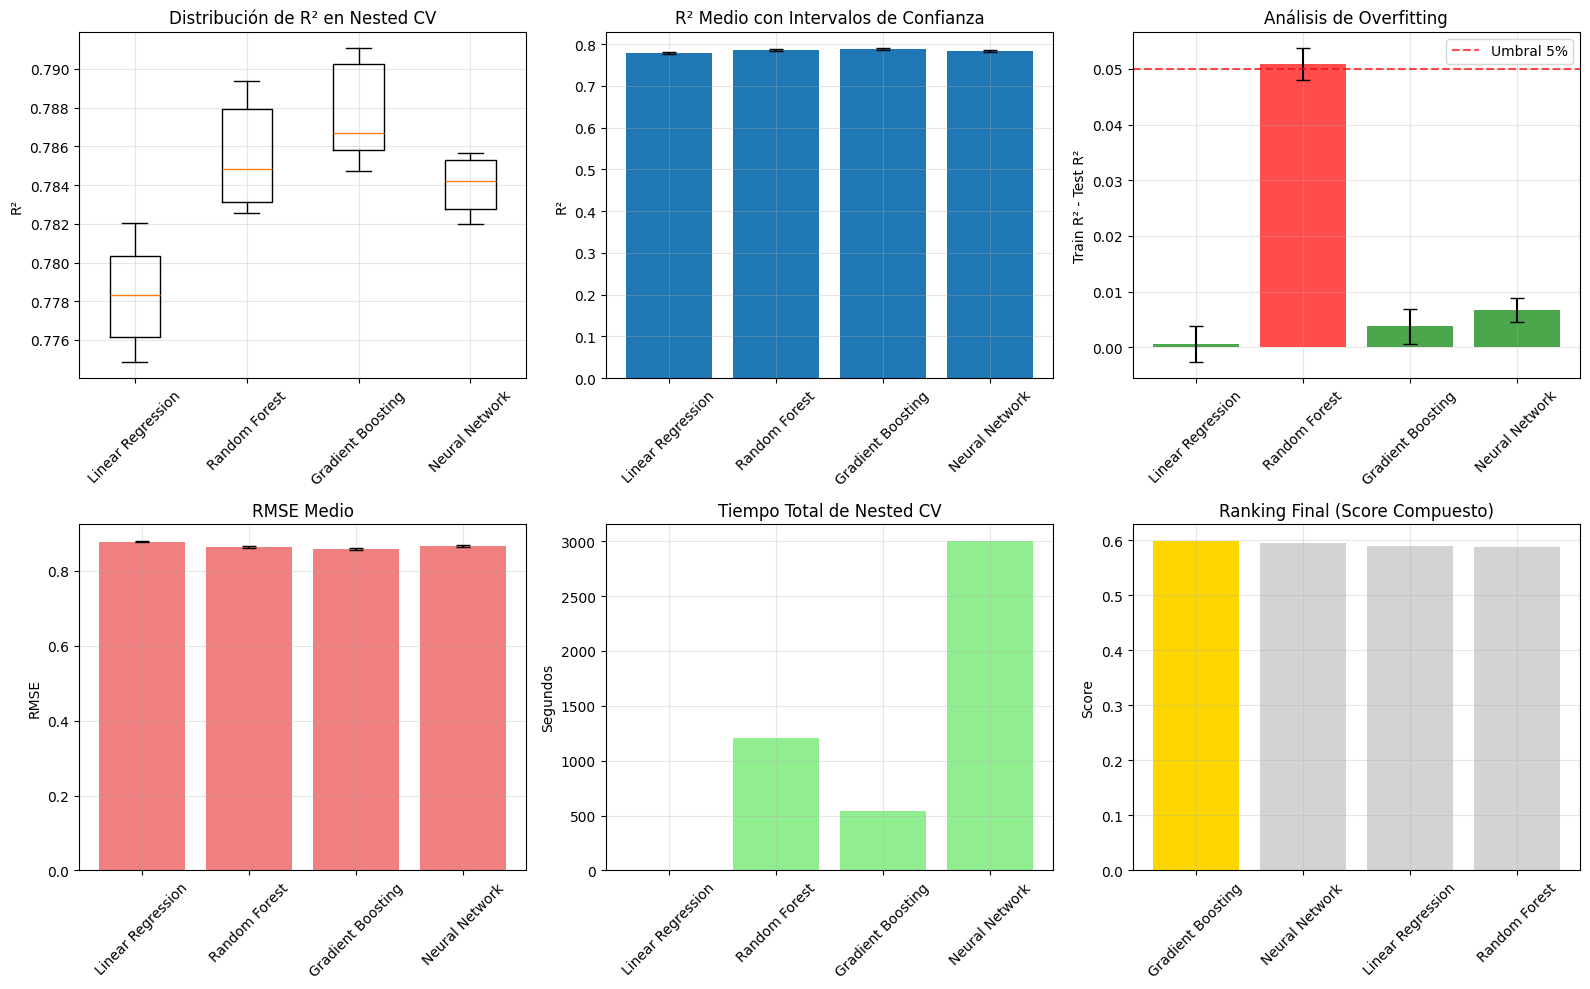


üèÜ MEJOR MODELO SEG√öN NESTED CV: Gradient Boosting
   ‚Ä¢ R¬≤ medio: 0.7877 ¬± 0.0025
   ‚Ä¢ RMSE medio: 0.8595 ¬± 0.0027
   ‚Ä¢ Overfitting: 0.0038 ¬± 0.0031

AN√ÅLISIS DE IMPORTANCIA DE FEATURES - NESTED CV

üìä Random Forest:

   Top 10 Features m√°s importantes (promedio en CV):
   Feature                        Importancia  Std        CV%       
   -----------------------------------------------------------------
   job_satisfaction_score         0.9447       0.0017     0.2     % ‚úÖ
   screen_time_before_sleep       0.0050       0.0002     4.7     % ‚úÖ
   sleep_hours                    0.0049       0.0002     3.8     % ‚úÖ
   stress_satisfaction_ratio      0.0047       0.0003     5.5     % ‚úÖ
   weekly_offline_hours           0.0046       0.0001     2.7     % ‚úÖ
   sleep_work_ratio               0.0045       0.0001     3.2     % ‚úÖ
   work_hours_per_day             0.0044       0.0001     2.4     % ‚úÖ
   number_of_notifications        0.0038       0.0001     3.2     % ‚

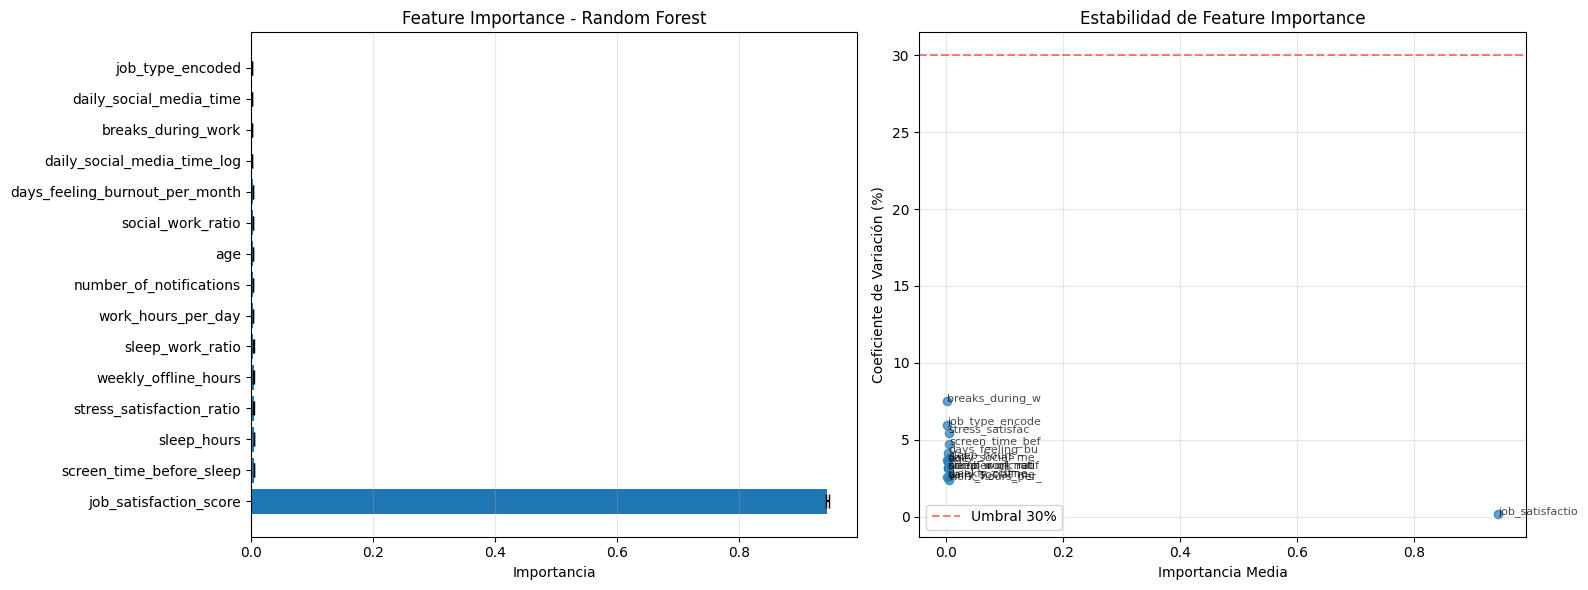


üìä Gradient Boosting:

   Top 10 Features m√°s importantes (promedio en CV):
   Feature                        Importancia  Std        CV%       
   -----------------------------------------------------------------
   job_satisfaction_score         0.9980       0.0001     0.0     % ‚úÖ
   stress_satisfaction_ratio      0.0005       0.0001     28.6    % ‚úÖ
   sleep_work_ratio               0.0002       0.0001     42.8    % ‚ö†Ô∏è
   sleep_hours                    0.0002       0.0001     30.2    % ‚ö†Ô∏è
   screen_time_before_sleep       0.0001       0.0000     33.4    % ‚ö†Ô∏è
   weekly_offline_hours           0.0001       0.0000     38.4    % ‚ö†Ô∏è
   social_work_ratio              0.0001       0.0001     52.3    % ‚ö†Ô∏è
   work_hours_per_day             0.0001       0.0000     45.8    % ‚ö†Ô∏è
   social_platform_preference_encoded 0.0001       0.0000     32.4    % ‚ö†Ô∏è
   number_of_notifications        0.0001       0.0000     23.3    % ‚úÖ


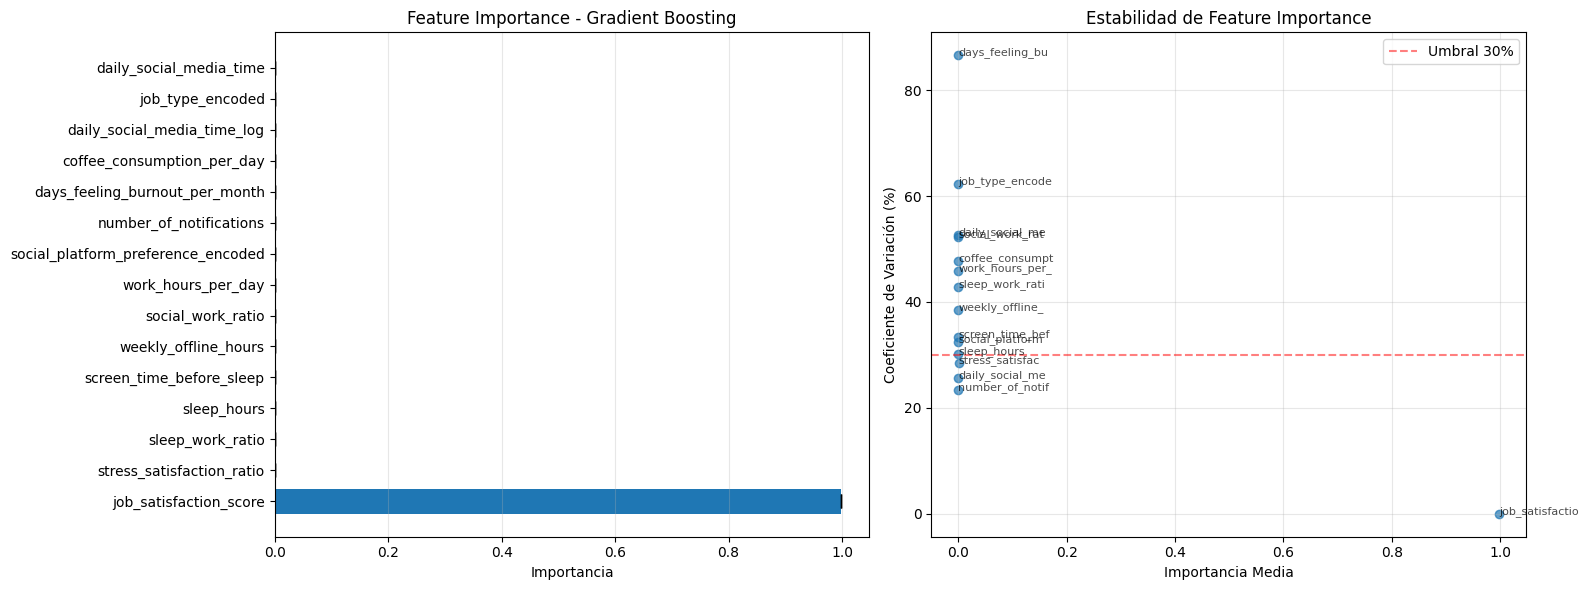


COMPARACI√ìN: NESTED CV vs EVALUACI√ìN SIMPLE

Mejor modelo seg√∫n evaluaci√≥n simple: Gradient Boosting
   R¬≤ en test: 0.7867

Mejor modelo seg√∫n nested CV: Gradient Boosting
   R¬≤ medio en nested CV: 0.7877 ¬± 0.0025

‚úÖ Ambos m√©todos coinciden en el mejor modelo!

üíæ Resultados de nested CV guardados en 'nested_cv_results.pkl'



‚úÖ NESTED CROSS-VALIDATION COMPLETADO!
   Total tiempo de ejecuci√≥n: 4752.6s


In [19]:
# ====================================================================
# 3.10 NESTED CROSS-VALIDATION COMPLETO
# ====================================================================

print("\n" + "="*70)
print("3.10 NESTED CROSS-VALIDATION")
print("="*70)

from sklearn.model_selection import KFold, GridSearchCV, cross_validate
import time
import numpy as np
import pandas as pd

def perform_nested_cv(X, y, models, feature_names, inner_cv=3, outer_cv=5, n_jobs=-1):
    """
    Implementa nested cross-validation para m√∫ltiples modelos.

    Parameters:
    -----------
    X : array-like
        Features transformadas
    y : array-like
        Variable objetivo
    models : dict
        Diccionario con modelos y sus par√°metros
    feature_names : list
        Nombres de las features
    inner_cv : int
        N√∫mero de folds para CV interno (optimizaci√≥n de hiperpar√°metros)
    outer_cv : int
        N√∫mero de folds para CV externo (evaluaci√≥n del modelo)
    n_jobs : int
        N√∫mero de cores a usar

    Returns:
    --------
    nested_results : dict
        Resultados completos del nested CV
    """

    # Configurar los folds
    inner_cv_splitter = KFold(n_splits=inner_cv, shuffle=True, random_state=42)
    outer_cv_splitter = KFold(n_splits=outer_cv, shuffle=True, random_state=42)

    nested_results = {}

    # Log a wandb el inicio del nested CV
    wandb.log({
        "nested_cv/started": True,
        "nested_cv/inner_folds": inner_cv,
        "nested_cv/outer_folds": outer_cv,
        "nested_cv/total_evaluations": inner_cv * outer_cv * len(models)
    })

    print(f"\nüîÑ Configuraci√≥n de Nested CV:")
    print(f"   ‚Ä¢ Folds externos (evaluaci√≥n): {outer_cv}")
    print(f"   ‚Ä¢ Folds internos (optimizaci√≥n): {inner_cv}")
    print(f"   ‚Ä¢ Modelos a evaluar: {len(models)}")
    print(f"   ‚Ä¢ Total de entrenamientos: {inner_cv * outer_cv * len(models)}")

    for model_name, model_config in models.items():
        print(f"\n{'='*60}")
        print(f"üöÄ NESTED CV: {model_name}")
        print(f"{'='*60}")

        start_time = time.time()

        # Si hay par√°metros para optimizar, usar GridSearchCV
        if model_config['params']:
            # GridSearchCV para el loop interno
            grid_search = GridSearchCV(
                estimator=model_config['model'],
                param_grid=model_config['params'],
                cv=inner_cv_splitter,
                scoring='r2',
                n_jobs=n_jobs,
                verbose=0
            )
            model_to_evaluate = grid_search
        else:
            # Si no hay par√°metros, usar el modelo directamente
            model_to_evaluate = model_config['model']

        # M√©tricas m√∫ltiples para evaluaci√≥n
        scoring_metrics = {
            'r2': 'r2',
            'neg_mse': 'neg_mean_squared_error',
            'neg_mae': 'neg_mean_absolute_error',
            'neg_rmse': 'neg_root_mean_squared_error'
        }

        # Nested Cross-Validation
        print("‚è≥ Ejecutando nested cross-validation...")
        nested_scores = cross_validate(
            model_to_evaluate, X, y,
            cv=outer_cv_splitter,
            scoring=scoring_metrics,
            return_train_score=True,
            return_estimator=True,
            n_jobs=n_jobs
        )

        # Procesar resultados
        test_r2 = nested_scores['test_r2']
        test_rmse = np.sqrt(-nested_scores['test_neg_mse'])
        test_mae = -nested_scores['test_neg_mae']
        train_r2 = nested_scores['train_r2']

        # Extraer mejores par√°metros de cada fold (si se us√≥ GridSearch)
        best_params_per_fold = []
        feature_importances_per_fold = []

        if model_config['params']:
            for estimator in nested_scores['estimator']:
                best_params_per_fold.append(estimator.best_params_)

                # Extraer feature importances si est√°n disponibles
                if hasattr(estimator.best_estimator_, 'feature_importances_'):
                    feature_importances_per_fold.append(estimator.best_estimator_.feature_importances_)

        # Calcular estad√≠sticas
        results = {
            'model_name': model_name,
            'test_r2_mean': test_r2.mean(),
            'test_r2_std': test_r2.std(),
            'test_r2_scores': test_r2,
            'test_rmse_mean': test_rmse.mean(),
            'test_rmse_std': test_rmse.std(),
            'test_mae_mean': test_mae.mean(),
            'test_mae_std': test_mae.std(),
            'train_r2_mean': train_r2.mean(),
            'train_r2_std': train_r2.std(),
            'overfitting_mean': (train_r2 - test_r2).mean(),
            'overfitting_std': (train_r2 - test_r2).std(),
            'fit_times': nested_scores['fit_time'],
            'total_time': time.time() - start_time,
            'best_params_per_fold': best_params_per_fold,
            'feature_importances_per_fold': feature_importances_per_fold
        }

        nested_results[model_name] = results

        # Log a wandb
        wandb.log({
            f"nested_cv/{model_name}/test_r2_mean": results['test_r2_mean'],
            f"nested_cv/{model_name}/test_r2_std": results['test_r2_std'],
            f"nested_cv/{model_name}/test_rmse_mean": results['test_rmse_mean'],
            f"nested_cv/{model_name}/test_mae_mean": results['test_mae_mean'],
            f"nested_cv/{model_name}/overfitting_mean": results['overfitting_mean'],
            f"nested_cv/{model_name}/total_time": results['total_time']
        })

        # Imprimir resumen
        print(f"\nüìä RESULTADOS - {model_name}:")
        print(f"   R¬≤ (test):     {results['test_r2_mean']:.4f} ¬± {results['test_r2_std']:.4f}")
        print(f"   RMSE (test):   {results['test_rmse_mean']:.4f} ¬± {results['test_rmse_std']:.4f}")
        print(f"   MAE (test):    {results['test_mae_mean']:.4f} ¬± {results['test_mae_std']:.4f}")
        print(f"   Overfitting:   {results['overfitting_mean']:.4f} ¬± {results['overfitting_std']:.4f}")
        print(f"   Tiempo total:  {results['total_time']:.1f}s")

        # An√°lisis de estabilidad de hiperpar√°metros
        if best_params_per_fold:
            print(f"\n   üîç Estabilidad de hiperpar√°metros:")
            analyze_param_stability(best_params_per_fold)

    return nested_results

def analyze_param_stability(best_params_list):
    """Analiza la estabilidad de los hiperpar√°metros entre folds."""
    if not best_params_list:
        return

    # Obtener todos los par√°metros √∫nicos
    all_params = set()
    for params in best_params_list:
        all_params.update(params.keys())

    for param in sorted(all_params):
        values = [fold_params.get(param) for fold_params in best_params_list]
        unique_values = list(set(values))

        if len(unique_values) == 1:
            print(f"      ‚Ä¢ {param}: {unique_values[0]} ‚úÖ (estable)")
        else:
            value_counts = pd.Series(values).value_counts()
            most_common = value_counts.index[0]
            stability_pct = (value_counts.iloc[0] / len(values)) * 100
            print(f"      ‚Ä¢ {param}: {most_common} ({stability_pct:.0f}% de los folds)")

def compare_nested_cv_results(nested_results):
    """
    Compara los resultados del nested CV y crea visualizaciones.
    """
    print("\n" + "="*70)
    print("COMPARACI√ìN DE RESULTADOS - NESTED CV")
    print("="*70)

    # Crear DataFrame comparativo
    comparison_data = []
    for model_name, results in nested_results.items():
        comparison_data.append({
            'Modelo': model_name,
            'R¬≤ (mean ¬± std)': f"{results['test_r2_mean']:.4f} ¬± {results['test_r2_std']:.4f}",
            'RMSE': f"{results['test_rmse_mean']:.4f} ¬± {results['test_rmse_std']:.4f}",
            'MAE': f"{results['test_mae_mean']:.4f} ¬± {results['test_mae_std']:.4f}",
            'Overfitting': f"{results['overfitting_mean']:.4f} ¬± {results['overfitting_std']:.4f}",
            'Tiempo (s)': f"{results['total_time']:.1f}"
        })

    comparison_df = pd.DataFrame(comparison_data)
    print("\n" + comparison_df.to_string(index=False))

    # Log tabla a wandb
    wandb.log({"nested_cv/comparison_table": wandb.Table(dataframe=comparison_df)})

    # Visualizaciones
    fig = plt.figure(figsize=(16, 10))

    # 1. Box plot de R¬≤ scores
    plt.subplot(2, 3, 1)
    r2_data = [results['test_r2_scores'] for results in nested_results.values()]
    labels = list(nested_results.keys())
    plt.boxplot(r2_data, labels=labels)
    plt.title('Distribuci√≥n de R¬≤ en Nested CV')
    plt.xticks(rotation=45)
    plt.ylabel('R¬≤')
    plt.grid(True, alpha=0.3)

    # 2. Comparaci√≥n de m√©tricas medias
    plt.subplot(2, 3, 2)
    x_pos = np.arange(len(labels))
    means = [results['test_r2_mean'] for results in nested_results.values()]
    stds = [results['test_r2_std'] for results in nested_results.values()]
    plt.bar(x_pos, means, yerr=stds, capsize=5)
    plt.xticks(x_pos, labels, rotation=45)
    plt.title('R¬≤ Medio con Intervalos de Confianza')
    plt.ylabel('R¬≤')
    plt.grid(True, alpha=0.3)

    # 3. An√°lisis de overfitting
    plt.subplot(2, 3, 3)
    overfitting_means = [results['overfitting_mean'] for results in nested_results.values()]
    overfitting_stds = [results['overfitting_std'] for results in nested_results.values()]
    colors = ['red' if x > 0.05 else 'green' for x in overfitting_means]
    plt.bar(x_pos, overfitting_means, yerr=overfitting_stds, color=colors, alpha=0.7, capsize=5)
    plt.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='Umbral 5%')
    plt.xticks(x_pos, labels, rotation=45)
    plt.title('An√°lisis de Overfitting')
    plt.ylabel('Train R¬≤ - Test R¬≤')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 4. RMSE comparison
    plt.subplot(2, 3, 4)
    rmse_means = [results['test_rmse_mean'] for results in nested_results.values()]
    rmse_stds = [results['test_rmse_std'] for results in nested_results.values()]
    plt.bar(x_pos, rmse_means, yerr=rmse_stds, color='lightcoral', capsize=5)
    plt.xticks(x_pos, labels, rotation=45)
    plt.title('RMSE Medio')
    plt.ylabel('RMSE')
    plt.grid(True, alpha=0.3)

    # 5. Tiempo de entrenamiento
    plt.subplot(2, 3, 5)
    times = [results['total_time'] for results in nested_results.values()]
    plt.bar(x_pos, times, color='lightgreen')
    plt.xticks(x_pos, labels, rotation=45)
    plt.title('Tiempo Total de Nested CV')
    plt.ylabel('Segundos')
    plt.grid(True, alpha=0.3)

    # 6. Ranking final
    plt.subplot(2, 3, 6)
    # Score compuesto: mayor R¬≤, menor RMSE, menor overfitting
    scores = []
    for results in nested_results.values():
        score = (
            results['test_r2_mean'] * 0.5 +  # 50% peso a R¬≤
            (1 - results['test_rmse_mean'] / max([r['test_rmse_mean'] for r in nested_results.values()])) * 0.3 +  # 30% peso inverso a RMSE
            (1 - abs(results['overfitting_mean'])) * 0.2  # 20% peso a bajo overfitting
        )
        scores.append(score)

    sorted_indices = np.argsort(scores)[::-1]
    sorted_labels = [labels[i] for i in sorted_indices]
    sorted_scores = [scores[i] for i in sorted_indices]

    colors = ['gold' if i == 0 else 'lightgray' for i in range(len(sorted_scores))]
    plt.bar(range(len(sorted_labels)), sorted_scores, color=colors)
    plt.xticks(range(len(sorted_labels)), sorted_labels, rotation=45)
    plt.title('Ranking Final (Score Compuesto)')
    plt.ylabel('Score')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    wandb.log({"nested_cv/comparison_dashboard": wandb.Image(fig)})
    plt.savefig('nested_cv_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Identificar mejor modelo
    best_model_idx = sorted_indices[0]
    best_model_name = labels[best_model_idx]
    best_results = nested_results[best_model_name]

    print(f"\nüèÜ MEJOR MODELO SEG√öN NESTED CV: {best_model_name}")
    print(f"   ‚Ä¢ R¬≤ medio: {best_results['test_r2_mean']:.4f} ¬± {best_results['test_r2_std']:.4f}")
    print(f"   ‚Ä¢ RMSE medio: {best_results['test_rmse_mean']:.4f} ¬± {best_results['test_rmse_std']:.4f}")
    print(f"   ‚Ä¢ Overfitting: {best_results['overfitting_mean']:.4f} ¬± {best_results['overfitting_std']:.4f}")

    return best_model_name, best_results

def analyze_feature_importance_stability(nested_results, feature_names):
    """
    Analiza la estabilidad de las importancias de features entre folds.
    """
    print("\n" + "="*70)
    print("AN√ÅLISIS DE IMPORTANCIA DE FEATURES - NESTED CV")
    print("="*70)

    for model_name, results in nested_results.items():
        if results['feature_importances_per_fold']:
            print(f"\nüìä {model_name}:")

            # Convertir a array y calcular estad√≠sticas
            importances_array = np.array(results['feature_importances_per_fold'])
            mean_importances = importances_array.mean(axis=0)
            std_importances = importances_array.std(axis=0)

            # Crear DataFrame
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance_mean': mean_importances,
                'importance_std': std_importances,
                'cv_coefficient': std_importances / (mean_importances + 1e-10)
            }).sort_values('importance_mean', ascending=False)

            # Mostrar top 10 features
            print("\n   Top 10 Features m√°s importantes (promedio en CV):")
            print(f"   {'Feature':<30} {'Importancia':<12} {'Std':<10} {'CV%':<10}")
            print("   " + "-"*65)

            for idx, row in importance_df.head(10).iterrows():
                stability = "‚úÖ" if row['cv_coefficient'] < 0.3 else "‚ö†Ô∏è"
                print(f"   {row['feature']:<30} {row['importance_mean']:<12.4f} "
                      f"{row['importance_std']:<10.4f} {row['cv_coefficient']*100:<8.1f}% {stability}")

            # Visualizaci√≥n
            if model_name in ['Random Forest', 'Gradient Boosting']:
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

                # Plot 1: Top features con error bars
                top_features = importance_df.head(15)
                y_pos = np.arange(len(top_features))
                ax1.barh(y_pos, top_features['importance_mean'],
                        xerr=top_features['importance_std'], capsize=5)
                ax1.set_yticks(y_pos)
                ax1.set_yticklabels(top_features['feature'])
                ax1.set_xlabel('Importancia')
                ax1.set_title(f'Feature Importance - {model_name}')
                ax1.grid(True, axis='x', alpha=0.3)

                # Plot 2: Estabilidad (CV%)
                ax2.scatter(top_features['importance_mean'],
                           top_features['cv_coefficient']*100, alpha=0.7)
                for idx, row in top_features.iterrows():
                    ax2.annotate(row['feature'][:15],
                               (row['importance_mean'], row['cv_coefficient']*100),
                               fontsize=8, alpha=0.7)
                ax2.set_xlabel('Importancia Media')
                ax2.set_ylabel('Coeficiente de Variaci√≥n (%)')
                ax2.set_title('Estabilidad de Feature Importance')
                ax2.axhline(y=30, color='red', linestyle='--', alpha=0.5,
                           label='Umbral 30%')
                ax2.legend()
                ax2.grid(True, alpha=0.3)

                plt.tight_layout()
                wandb.log({f"nested_cv/feature_importance/{model_name.lower().replace(' ', '_')}":
                          wandb.Image(fig)})
                plt.show()

# EJECUTAR NESTED CROSS-VALIDATION
print("\nüöÄ INICIANDO NESTED CROSS-VALIDATION")
print("="*70)

# Usar los mismos datos transformados
nested_cv_results = perform_nested_cv(
    X=X_transformed,
    y=y,
    models=models,
    feature_names=feature_names,
    inner_cv=3,  # 3 folds para optimizaci√≥n de hiperpar√°metros
    outer_cv=5   # 5 folds para evaluaci√≥n
)

# Comparar resultados
best_model_nested, best_results_nested = compare_nested_cv_results(nested_cv_results)

# Analizar estabilidad de feature importance
analyze_feature_importance_stability(nested_cv_results, feature_names)

# Comparaci√≥n con resultados anteriores (sin nested CV)
print("\n" + "="*70)
print("COMPARACI√ìN: NESTED CV vs EVALUACI√ìN SIMPLE")
print("="*70)

print(f"\nMejor modelo seg√∫n evaluaci√≥n simple: {best_model_name}")
print(f"   R¬≤ en test: {results[best_model_name]['test_r2']:.4f}")

print(f"\nMejor modelo seg√∫n nested CV: {best_model_nested}")
print(f"   R¬≤ medio en nested CV: {best_results_nested['test_r2_mean']:.4f} ¬± {best_results_nested['test_r2_std']:.4f}")

# An√°lisis de la diferencia
if best_model_name == best_model_nested:
    print("\n‚úÖ Ambos m√©todos coinciden en el mejor modelo!")
else:
    print("\n‚ö†Ô∏è  Los m√©todos difieren en la selecci√≥n del mejor modelo.")
    print("   Nested CV es m√°s robusto y confiable para la selecci√≥n final.")

# Guardar resultados de nested CV
import pickle
with open('nested_cv_results.pkl', 'wb') as f:
    pickle.dump(nested_cv_results, f)
print("\nüíæ Resultados de nested CV guardados en 'nested_cv_results.pkl'")

# Log final a wandb
wandb.summary.update({
    "nested_cv/best_model": best_model_nested,
    "nested_cv/best_r2_mean": best_results_nested['test_r2_mean'],
    "nested_cv/best_r2_std": best_results_nested['test_r2_std'],
    "nested_cv/completed": True
})

wandb.finish()

print("\n‚úÖ NESTED CROSS-VALIDATION COMPLETADO!")
print(f"   Total tiempo de ejecuci√≥n: {sum([r['total_time'] for r in nested_cv_results.values()]):.1f}s")